# Bayesian ML Final Project - Loan's Interest Rate Prediction

## Set UP

In [ ]:
!pip install lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import joblib
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

In [ ]:
# Load datasets
metadata_path = "Metadata.csv"
raw_data_path = "Data for Cleaning _ Modeling.csv"
holdout_path = "Holdout for Testing.csv"

metadata_df = pd.read_csv("Metadata.csv", encoding="latin1")
raw_data_df = pd.read_csv("Data for Cleaning _ Modeling.csv")


#metadata_df = pd.read_csv(metadata_path, encoding="latin1")
#raw_data_df = pd.read_csv(raw_data_path, encoding="latin1", error_bad_lines=False)
#holdout_df = pd.read_csv(holdout_path, encoding="latin1")

## EDA

In [ ]:
# Create DataFrame with column metadata
column_info_df = pd.DataFrame({
    "Column Name": raw_data_df.columns,
    "Missing Values": raw_data_df.isna().sum().values,
    "Unique Values": raw_data_df.nunique().values,
    "Data Type": raw_data_df.dtypes.values,
    "Definition": metadata_df.set_index("Variable").loc[raw_data_df.columns, "Definition"].values
})
column_info_df

,Column Name,Missing Values,Unique Values,Data Type,Definition
0,X1,36189,480,object,Interest Rate on the loan
1,X2,0,238215,int64,A unique id for the loan.
2,X3,0,238215,int64,A unique id assigned for the borrower.
3,X4,0,1289,object,Loan amount requested
4,X5,0,1292,object,Loan amount funded
5,X6,0,7015,object,Investor-funded portion of loan
6,X7,0,2,object,Number of payments (36 or 60)
7,X8,36430,7,object,Loan grade
8,X9,36430,35,object,Loan subgrade
9,X10,14957,140290,object,Employer or job title (self-filled)


## Cleaning

In [ ]:
# Data Cleaning Function
def clean_data(df, is_holdout=False):
    df = df.copy()

    # Drop unnecessary columns
    cols_to_drop = ["X2", "X3", "X10", "X16", "X18", "X19", "X25", "X26"]
    df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    # Drop columns with excessive missing values
    cols_with_many_nans = ["X8", "X9", "X12", "X16", "X25", "X26"]
    df.drop(columns=cols_with_many_nans, inplace=True, errors='ignore')

    # Drop rows where the target variable (X1) is missing, unless it's holdout data
    if not is_holdout:
        df = df.dropna(subset=['X1'])

    # Drop rows that are completely empty or missing most values
    df = df.dropna(thresh=int(0.5 * len(df.columns)))

    # Convert percentage and currency columns to numeric
    for col in ["X1", "X4", "X5", "X6", "X30"]:
        df[col] = df[col].replace({'%': '', '\$': '', ',': ''}, regex=True).astype(float)

    # Convert date columns to datetime format
    df["X15"] = pd.to_datetime(df["X15"], format='%b-%y', errors='coerce')
    df["X23"] = pd.to_datetime(df["X23"], format='%b-%y', errors='coerce')

    # Impute categorical variables with the most frequent value
    categorical_cols = ["X7", "X11", "X13", "X14", "X17", "X20", "X32"]
    df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

    # Impute numerical variables with the median
    numerical_cols = ["X21", "X22", "X24", "X27", "X28", "X29", "X30","X31"]
    df[numerical_cols] = df[numerical_cols].apply(lambda x: x.fillna(x.median()))

    # Drop rows where essential columns are missing
    essential_cols = ["X7", "X14"]
    df = df.dropna(subset=essential_cols)

    # Remove X1 from holdout data
    if is_holdout:
        df = df.drop(columns=['X1'], errors='ignore')

    return df

In [ ]:
# clean training data
df_cleaned = clean_data(raw_data_df)
df_cleaned.head()

,X1,X4,X5,X6,X7,X11,X13,X14,X15,X17,X20,X21,X22,X23,X24,X27,X28,X29,X30,X31,X32
0,11.89,25000.0,25000.0,19080.0,36 months,< 1 year,85000.0,VERIFIED - income,2009-08-01,debt_consolidation,CA,19.48,0.0,1994-02-01,0.0,10.0,0.0,28854.0,52.1,42.0,f
1,10.71,7000.0,7000.0,673.0,36 months,< 1 year,65000.0,not verified,2008-05-01,credit_card,NY,14.29,0.0,2000-10-01,0.0,7.0,0.0,33623.0,76.7,7.0,f
2,16.99,25000.0,25000.0,24725.0,36 months,1 year,70000.0,VERIFIED - income,2014-08-01,debt_consolidation,NY,10.50,0.0,2000-06-01,0.0,10.0,0.0,19878.0,66.3,17.0,f
3,13.11,1200.0,1200.0,1200.0,36 months,10+ years,54000.0,not verified,2010-03-01,debt_consolidation,TX,5.47,0.0,1985-01-01,0.0,5.0,0.0,2584.0,40.4,31.0,f
4,13.57,10800.0,10800.0,10692.0,36 months,6 years,32000.0,not verified,2009-11-01,debt_consolidation,CT,11.63,0.0,1996-12-01,1.0,14.0,0.0,3511.0,25.6,40.0,f


## Feature Engineering

In [ ]:
# Feature Engineering Function
def feature_engineering(df):
    df = df.copy()

    # Encode categorical variables
    label_encoder = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        if df[col].nunique() == 2:
            df[col] = label_encoder.fit_transform(df[col])
        else:
            df[col] = df[col].astype('category').cat.codes

    # Create a new feature: Days between the two date columns
    df["Days_Between_X15_X23"] = (df["X15"] - df["X23"]).dt.days.fillna(0).astype(float)

    # Create interaction feature: Ratio of funded amount to requested amount
    df["Funded_to_Requested_Ratio"] = df["X5"] / df["X4"]

    # Create interaction feature: Loan burden relative to income
    df["Loan_to_Income_Ratio"] = df["X4"] / df["X13"]

    # Create combined credit lines feature while handling division by zero
    df["Active_Credit_Line_Ratio"] = df["X31"] / df["X27"].replace(0, np.nan)
    df["Active_Credit_Line_Ratio"] = df["Active_Credit_Line_Ratio"].fillna(0)

    # Drop the original date columns and highly correlated one
    df.drop(columns=["X5", "X6", "X15", "X23", "X27"], inplace=True, errors='ignore')


    return df

In [ ]:
df_engineered = feature_engineering(df_cleaned)
df_engineered.head()

,X1,X4,X7,X11,X13,X14,X17,X20,X21,X22,X24,X28,X29,X30,X31,X32,Days_Between_X15_X23,Funded_to_Requested_Ratio,Loan_to_Income_Ratio,Active_Credit_Line_Ratio
0,11.89,25000.0,0,10,85000.0,0,2,4,19.48,0.0,0.0,0.0,28854.0,52.1,42.0,0,5660.0,1.0,0.294118,4.200000
1,10.71,7000.0,0,10,65000.0,2,1,33,14.29,0.0,0.0,0.0,33623.0,76.7,7.0,0,2769.0,1.0,0.107692,1.000000
2,16.99,25000.0,0,0,70000.0,0,2,33,10.50,0.0,0.0,0.0,19878.0,66.3,17.0,0,5174.0,1.0,0.357143,1.700000
3,13.11,1200.0,0,1,54000.0,2,2,42,5.47,0.0,0.0,0.0,2584.0,40.4,31.0,0,9190.0,1.0,0.022222,6.200000
4,13.57,10800.0,0,6,32000.0,2,2,6,11.63,0.0,1.0,0.0,3511.0,25.6,40.0,0,4718.0,1.0,0.337500,2.857143


## Standardization

In [ ]:
# Standardization Function
def standardize_data(df):
    df = df.copy()
    scaler = StandardScaler()

    # Identify continuous numerical columns (excluding categorical ones)
    categorical_cols = df.select_dtypes(include=['int8', 'int64']).columns
    numerical_cols = [col for col in df.columns if col not in categorical_cols and col != "X1"]

    # Apply StandardScaler to numerical columns
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    return df

In [ ]:
df_standardized = standardize_data(df_engineered)
df_standardized.head()

,X1,X4,X7,X11,X13,X14,X17,X20,X21,X22,X24,X28,X29,X30,X31,X32,Days_Between_X15_X23,Funded_to_Requested_Ratio,Loan_to_Income_Ratio,Active_Credit_Line_Ratio
0,11.89,1.368266,0,10,0.305728,0,2,4,0.399916,-0.333534,-0.783783,-0.250851,0.678669,-0.192466,1.587312,0,0.055428,0.084002,0.656627,1.773753
1,10.71,-0.848769,0,10,-0.102678,2,1,33,-0.285709,-0.333534,-0.783783,-0.250851,0.928360,0.823981,-1.538716,0,-0.984928,0.084002,-0.957463,-1.339870
2,16.99,1.368266,0,0,-0.000577,0,2,33,-0.786388,-0.333534,-0.783783,-0.250851,0.208712,0.394263,-0.645565,0,-0.119464,0.084002,1.202306,-0.658765
3,13.11,-1.563146,0,1,-0.327302,2,2,42,-1.450876,-0.333534,-0.783783,-0.250851,-0.696752,-0.675899,0.604846,0,1.325734,0.084002,-1.697472,3.719767
4,13.57,-0.380728,0,6,-0.776548,2,2,6,-0.637109,-0.333534,0.178156,-0.250851,-0.648217,-1.287420,1.408682,0,-0.283561,0.084002,1.032236,0.467143


In [ ]:
# Create a dictionary mapping old column names to new names
column_mapping = {
    "X1": "Interest_Rate",
    "X4": "Loan_Amount_Requested",
    "X7": "Number_of_Payments",
    "X11": "Years_Employed",
    "X13": "Annual_Income",
    "X14": "Income_Verified",
    "X17": "Loan_Category",
    "X20": "State",
    "X21": "Debt_to_Income_Ratio",
    "X22": "Delinquencies_2Y",
    "X24": "Credit_Inquiries_6M",
    "X28": "Derogatory_Public_Records",
    "X29": "Total_Credit_Revolving_Balance",
    "X30": "Revolving_Utilization_Rate",
    "X31": "Total_Credit_Lines",
    "X32": "Initial_Listing_Status"
}

# Rename columns in DataFrame
df_standardized.rename(columns=column_mapping, inplace=True)

# Display the updated column names
df_standardized.head()


,Interest_Rate,Loan_Amount_Requested,Number_of_Payments,Years_Employed,Annual_Income,Income_Verified,Loan_Category,State,Debt_to_Income_Ratio,Delinquencies_2Y,Credit_Inquiries_6M,Derogatory_Public_Records,Total_Credit_Revolving_Balance,Revolving_Utilization_Rate,Total_Credit_Lines,Initial_Listing_Status,Days_Between_X15_X23,Funded_to_Requested_Ratio,Loan_to_Income_Ratio,Active_Credit_Line_Ratio
0,11.89,1.368266,0,10,0.305728,0,2,4,0.399916,-0.333534,-0.783783,-0.250851,0.678669,-0.192466,1.587312,0,0.055428,0.084002,0.656627,1.773753
1,10.71,-0.848769,0,10,-0.102678,2,1,33,-0.285709,-0.333534,-0.783783,-0.250851,0.928360,0.823981,-1.538716,0,-0.984928,0.084002,-0.957463,-1.339870
2,16.99,1.368266,0,0,-0.000577,0,2,33,-0.786388,-0.333534,-0.783783,-0.250851,0.208712,0.394263,-0.645565,0,-0.119464,0.084002,1.202306,-0.658765
3,13.11,-1.563146,0,1,-0.327302,2,2,42,-1.450876,-0.333534,-0.783783,-0.250851,-0.696752,-0.675899,0.604846,0,1.325734,0.084002,-1.697472,3.719767
4,13.57,-0.380728,0,6,-0.776548,2,2,6,-0.637109,-0.333534,0.178156,-0.250851,-0.648217,-1.287420,1.408682,0,-0.283561,0.084002,1.032236,0.467143


In [ ]:
# Save df_standardized to a CSV file
df_standardized.to_csv("df_standardized.csv", index=False)

## Inspect multicollinearity

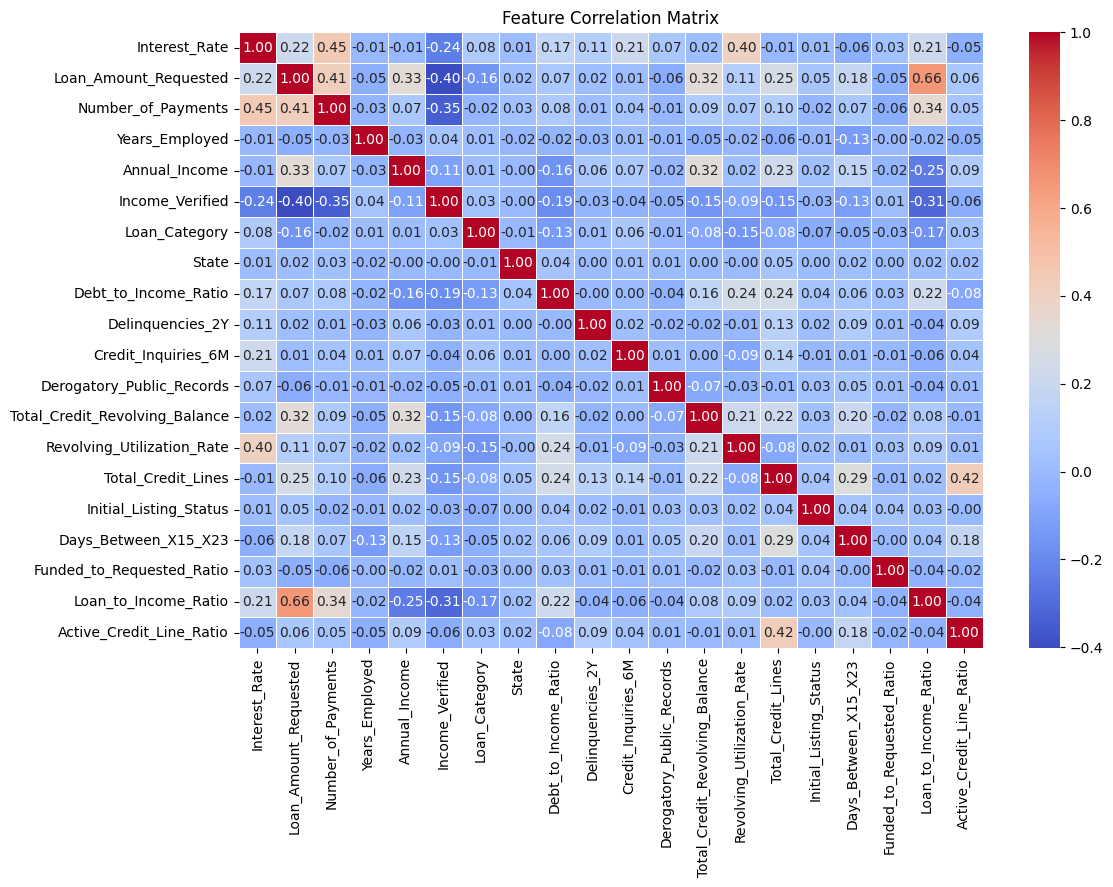

In [ ]:
# Inspect multicollinearity
correlation_matrix = df_standardized.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

## Training

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset (80% train, 20% test)
train_df, test_df = train_test_split(df_standardized, test_size=0.2, random_state=42)

# Save train and test datasets as CSV files
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

print("Train and test datasets saved successfully!")

Train and test datasets saved successfully!


In [ ]:
# Get the shape (rows, columns) of df_standardized, train_df, and test_df
df_standardized_shape = df_standardized.shape
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Display the results
df_standardized_shape, train_df_shape, test_df_shape


((202025, 20), (161620, 20), (40405, 20))